In [1]:
# importing libraries

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

%matplotlib inline

In [2]:
# reading traning and test data

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
# dropping the rows with null values

df_train = df_train.dropna()

In [5]:
df_train.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [6]:
# checking for duplicates

df_duplicated = df_train[df_train.duplicated(['qid1','qid2','question1','question2'], keep ='first')]
df_duplicated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
id              0 non-null int64
qid1            0 non-null int64
qid2            0 non-null int64
question1       0 non-null object
question2       0 non-null object
is_duplicate    0 non-null int64
dtypes: int64(4), object(2)
memory usage: 0.0+ bytes


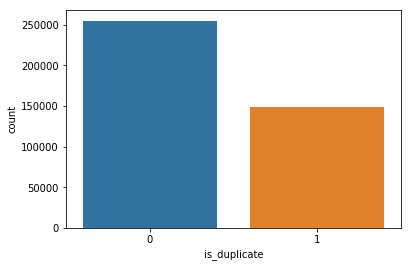

In [7]:
# Analysing the is_duplicate variable

sns.countplot(x = "is_duplicate", data = df_train)
plt.show()

In [8]:
# checking if same question is present in both the columns

df_train[(df_train.qid1 == df_train.qid2)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 6 columns):
id              0 non-null int64
qid1            0 non-null int64
qid2            0 non-null int64
question1       0 non-null object
question2       0 non-null object
is_duplicate    0 non-null int64
dtypes: int64(4), object(2)
memory usage: 0.0+ bytes


In [9]:
# creating a set of all unique values of qid1

q1 = set(df_train["qid1"].unique())

# creating a set of all unique values of qid2

q2 = set(df_train["qid2"].unique())

print("total number of questions in the dataset:", len(q1.union(q2)))
print("number of questions occuring in both columns:", len(q1.intersection(q2)))

total number of questions in the dataset: 537929
number of questions occuring in both columns: 52085


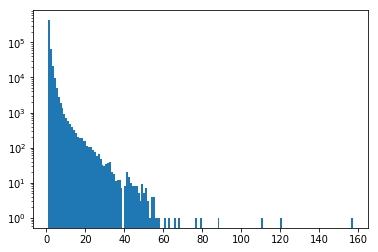

the maximum number of times a questions has occured: 157


In [10]:
# creating a list of values in qid1

list_1 = df_train["qid1"].tolist()

# creating a list of values in qid1

list_2 = df_train["qid2"].tolist()

# concatenating both lists                                 

total_list = list_1 + list_2

counter = Counter(total_list)

plt.hist(counter.values(), bins = 160)
plt.yscale('log', nonposy = 'clip')
plt.show()

print("the maximum number of times a questions has occured:", max(counter.values()))

# Text Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [12]:
# functions for removing html tags, punctuations, contractions and expansions

def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext

def cleanpunc(data):
    cleandata = re.sub(r'[^A-Za-z]+',r' ',data)
    cleandata = re.sub(r'[?|!|\'|"|#]',r'',cleandata)
    cleandata = re.sub(r'[.|,|)|(|/|\|<|>|:|;|{|}|*|&|^|%|$|!]',r'',cleandata)
    return cleandata
    
def preprocess(data):
    data = str(data).lower()
    data = re.sub(r",000,000", r"m", data)
    data = re.sub(r",000", r"k", data)
    data = re.sub(r"′", r"'",data)
    data = re.sub(r"’", r"'",data)
    data = re.sub(r"'t", r" not", data)
    data = re.sub(r"n't", r" not", data)
    data = re.sub(r"i'm", r"i am", data)
    data = re.sub(r"'s", r" is", data)
    data = re.sub(r"'ve'", r" have", data)
    data = re.sub(r"wont", r"will not", data)
    data = re.sub(r"cant", r"can not", data)
    data = re.sub(r"shouldnt", r"should not", data)
    data = re.sub(r"cannot", r"can not", data)
    data = re.sub(r"%", r" percent ", data)
    data = re.sub(r"$", r" dollar ", data)
    data = re.sub(r"'ll", r" will", data)
    data = re.sub(r"€", r" euro ", data)
    data = re.sub(r"₹", r" rupee ", data)
    data = re.sub(r"([0-9]+)000000", r"\1m", data)
    data = re.sub(r"([0-9]+)000", r"\1k", data)
    return data              

In [13]:
# removing hrml tags
# removing punctuations
# performed contractions and expansions

Ques1_preprocess = []
Ques2_preprocess = []

for ques1, ques2 in zip(df_train["question1"].values, df_train["question2"].values):
    
    ques1 = striphtml(ques1)
    
    ques2 = striphtml(ques2)
    
    ques1 = cleanpunc(ques1)
    
    ques2 = cleanpunc(ques2)
    
    ques1 = preprocess(ques1)
    
    ques2 = preprocess(ques2)
    
    Ques1_preprocess.append(ques1)
                        
    Ques2_preprocess.append(ques2)

In [14]:
df_train["question1"] = Ques1_preprocess
df_train["question2"] = Ques2_preprocess

In [15]:
# tokenization and stemming

Questions1 = []
Questions2 = []

for ques1, ques2 in zip(df_train["question1"].values, df_train["question2"].values):
    
    words1 = word_tokenize(str(ques1))
    
    words2 = word_tokenize(str(ques2))
    
    question1 =' '.join(str(stemmer.stem(j)) for j in words1 if (len(j)>1))
                      
    question2 =' '.join(str(stemmer.stem(j)) for j in words2  if (len(j)>1))                  
    
    Questions1.append(question1)
                        
    Questions2.append(question2)                    

In [16]:
df_train["question1"] = Questions1
df_train["question2"] = Questions2

In [17]:
df_train.head()

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guid to invest in sha...   
1   1     3     4  what is the stori of kohinoor koh noor diamond...   
2   2     5     6  how can increas the speed of my internet conne...   
3   3     7     8     whi am mental veri lone how can solv it dollar   
4   4     9    10  which one dissolv in water quik sugar salt met...   

                                           question2  is_duplicate  
0  what is the step by step guid to invest in sha...             0  
1  what would happen if the indian govern stole t...             0  
2  how can internet speed be increas by hack thro...             0  
3  find the remaind when math math is divid by do...             0  
4       which fish would surviv in salt water dollar             0

# Basic Feature Engineering

In [18]:
# Feature engineering

SAFE_DIV = 0.0001

q1_length = np.zeros(404287)
q2_length = np.zeros(404287)
x = np.zeros(404287)
y = np.zeros(404287)
nwords_common = np.zeros(404287)
union_words = np.zeros(404287)

for i in range(404287):
    q1_length[i] = len(df_train["question1"].values[i])
    
for i in range(404287):
    q2_length[i] = len(df_train["question2"].values[i])    

for i in range(404287):
    x[i] = len(df_train["question1"].values[i].split())
    
for i in range(404287):
    y[i] = len(df_train["question2"].values[i].split())    

for i in range(404287):
    words_x = df_train["question1"].values[i].split()
    words_y = df_train["question2"].values[i].split()
    nwords_common[i] = len(set(words_x).intersection(set(words_y)))
    
for i in range(404287):
    words_x = df_train["question1"].values[i].split()
    words_y = df_train["question2"].values[i].split()
    union_words[i] = len(set(words_x).union(set(words_y))) 
    
df_train["freq_q1"] = df_train.groupby(['qid1'])['qid1'].transform('count')

df_train["freq_q2"] = df_train.groupby(['qid2'])['qid2'].transform('count')    

df_train["freq_q1 + freq_q2"] = df_train["freq_q1"] + df_train["freq_q2"]

df_train["freq_q1 - freq_q2"] = df_train["freq_q1"] - df_train["freq_q2"]
    
df_train["q1_len"] =  q1_length

df_train["q2_len"] =  q2_length      
    
df_train["t_common"] = nwords_common 

df_train["t_total"] = x + y

df_train["t_diff"] = abs(x - y)

df_train["t_mean"] = (x + y)/2

df_train["t_union"] = union_words

df_train["ctc_total"] = df_train["t_common"]/df_train["t_total"]

df_train["ctc_diff"] = df_train["t_common"]/(df_train["t_diff"] + SAFE_DIV)

df_train["ctc_union"] = df_train["t_common"]/df_train["t_union"]

In [19]:
df_train.head()

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guid to invest in sha...   
1   1     3     4  what is the stori of kohinoor koh noor diamond...   
2   2     5     6  how can increas the speed of my internet conne...   
3   3     7     8     whi am mental veri lone how can solv it dollar   
4   4     9    10  which one dissolv in water quik sugar salt met...   

                                           question2  is_duplicate  freq_q1  \
0  what is the step by step guid to invest in sha...             0        1   
1  what would happen if the indian govern stole t...             0        4   
2  how can internet speed be increas by hack thro...             0        1   
3  find the remaind when math math is divid by do...             0        1   
4       which fish would surviv in salt water dollar             0        3   

   freq_q2  freq_q1 + freq_q2  freq_q1 - freq_q2  q1_len  q2_len  t_common  \
0        1                  2                  0    71.0    62.0      12.0   
1        1                  5                  3    53.0    86.0       7.0   
2        1                  2                  0    69.0    60.0       6.0   
3        1                  2                  0    46.0    50.0       1.0   
4        1                  4                  2    75.0    44.0       5.0   

   t_total  t_diff  t_mean  t_union  ctc_total      ctc_diff  ctc_union  
0     28.0     2.0    14.0     13.0   0.428571      5.999700   0.923077  
1     25.0     5.0    12.5     17.0   0.280000      1.399972   0.411765  
2     24.0     2.0    12.0     18.0   0.250000      2.999850   0.333333  
3     20.0     0.0    10.0     18.0   0.050000  10000.000000   0.055556  
4     22.0     6.0    11.0     17.0   0.227273      0.833319   0.294118

# Feature Analysis

## Univariate analysis

(0, 20)

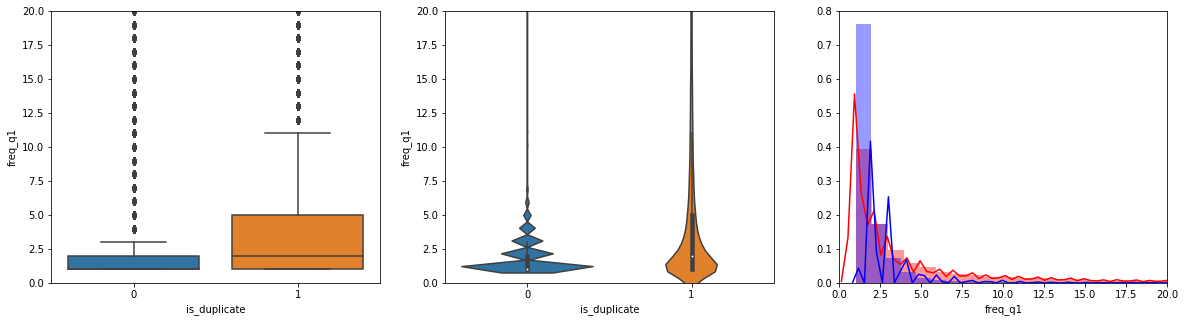

In [20]:
# Analysing freq_q1

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "freq_q1", data = df_train)
plt.ylim(0,20)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "freq_q1", data = df_train)
plt.ylim(0,20)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['freq_q1'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['freq_q1'][0:] , label = "0" , color = 'blue' )
plt.xlim(0,20)

(0, 20)

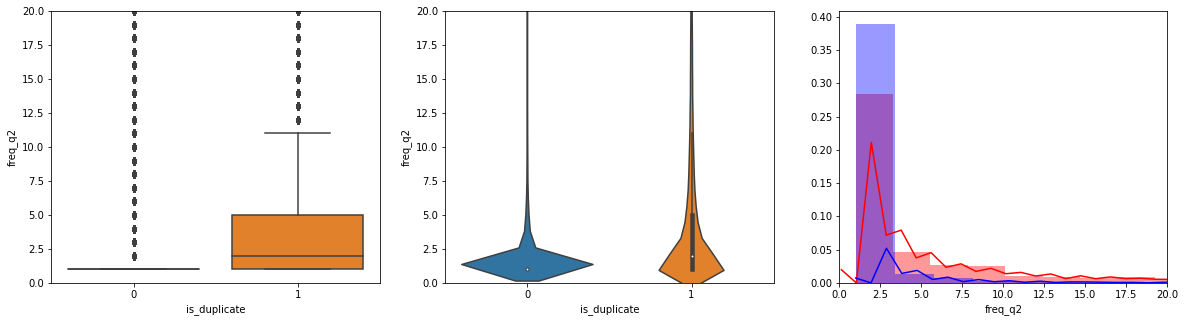

In [21]:
# Analysing freq_q2

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "freq_q2", data = df_train)
plt.ylim(0,20)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "freq_q2", data = df_train)
plt.ylim(0,20)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['freq_q2'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['freq_q2'][0:] , label = "0" , color = 'blue' )
plt.xlim(0,20)

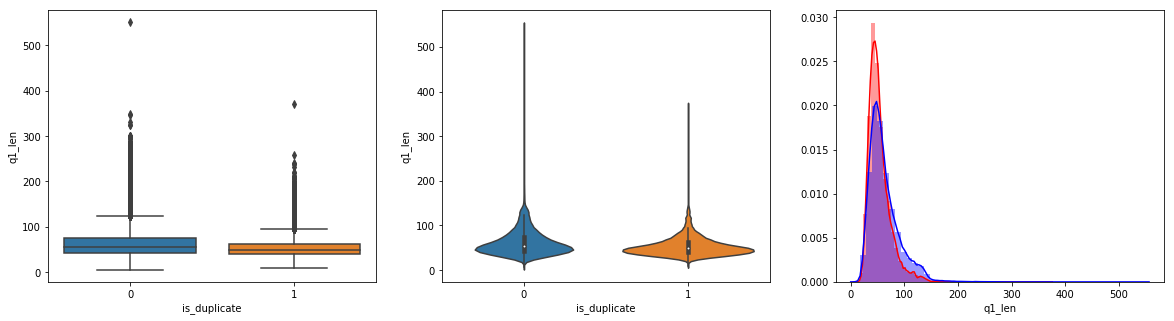

In [22]:
# Analysing q1_len

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "q1_len", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "q1_len", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['q1_len'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['q1_len'][0:] , label = "0" , color = 'blue' )

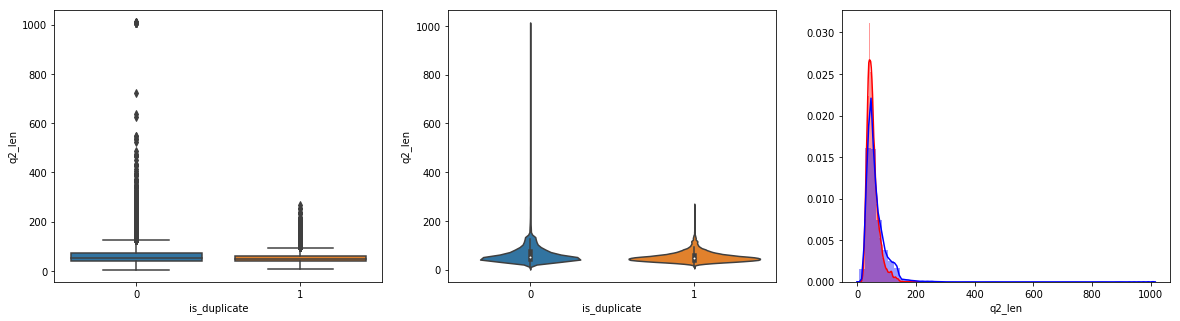

In [23]:
# Analysing q2_len

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "q2_len", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "q2_len", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['q2_len'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['q2_len'][0:] , label = "0" , color = 'blue' )

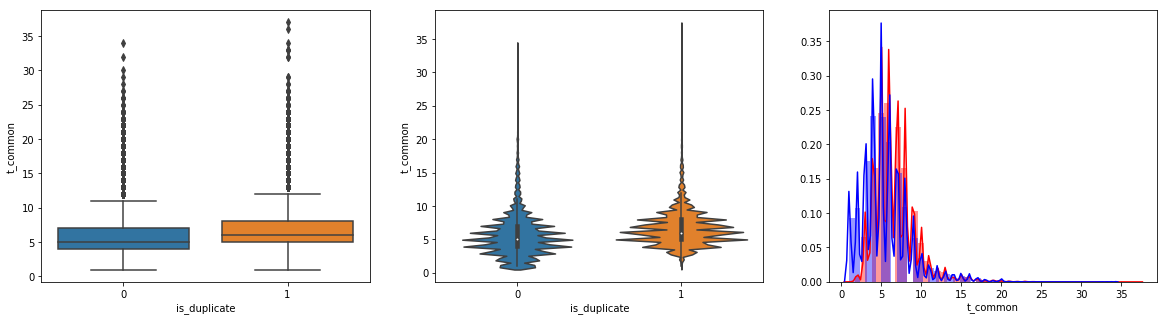

In [24]:
#Analysing t_common

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "t_common", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "t_common", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['t_common'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['t_common'][0:] , label = "0" , color = 'blue' )

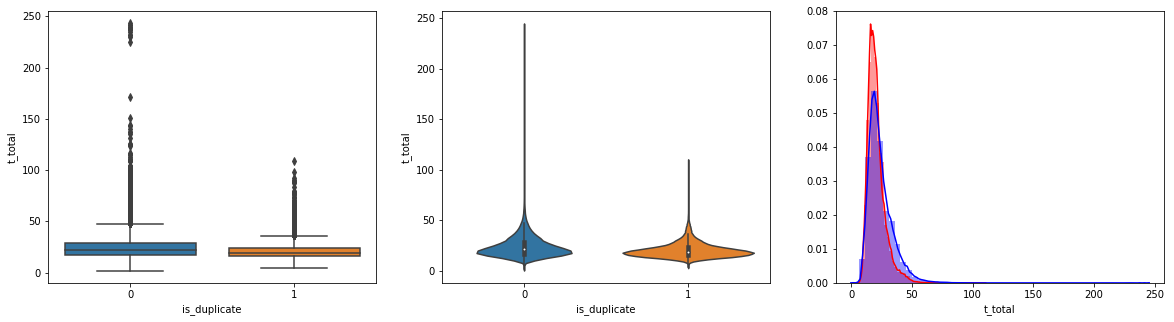

In [25]:
#Analysing t_total

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "t_total", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "t_total", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['t_total'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['t_total'][0:] , label = "0" , color = 'blue')

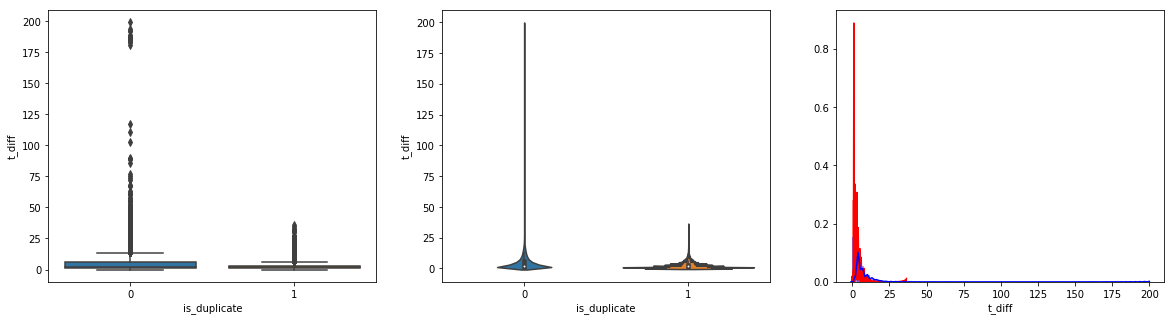

In [26]:
#Analysing t_diff

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "t_diff", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "t_diff", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['t_diff'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['t_diff'][0:] , label = "0" , color = 'blue')

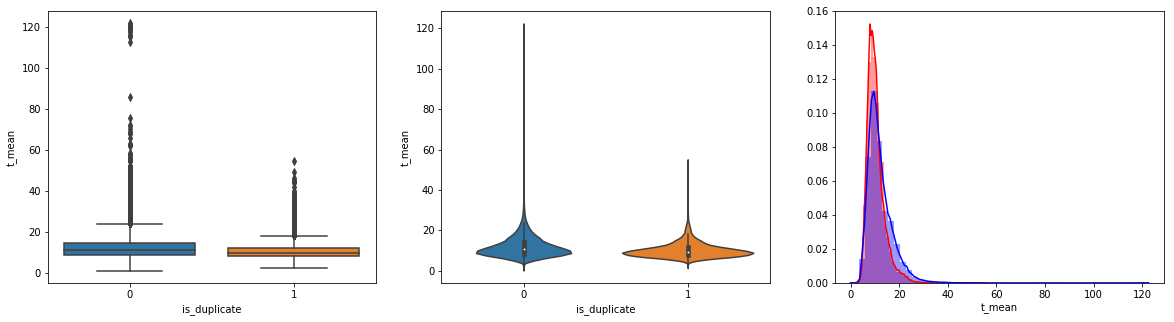

In [27]:
#Analysing t_mean

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "t_mean", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "t_mean", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['t_mean'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['t_mean'][0:] , label = "0" , color = 'blue')

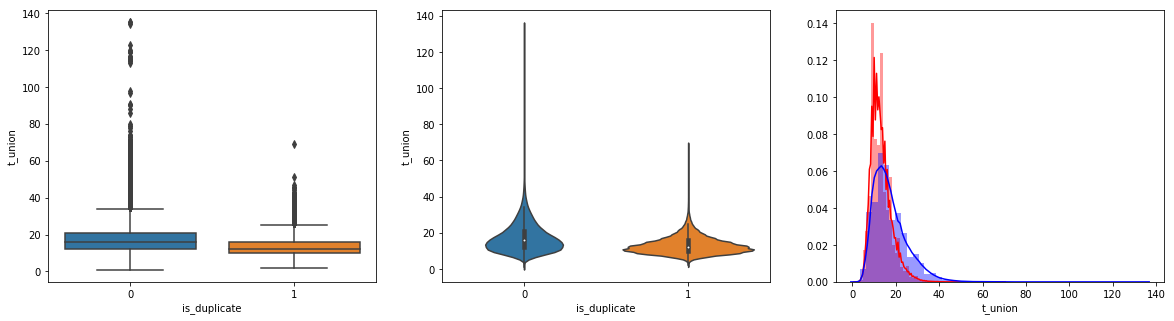

In [28]:
#Analysing t_union

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "t_union", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "t_union", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['t_union'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['t_union'][0:] , label = "0" , color = 'blue')

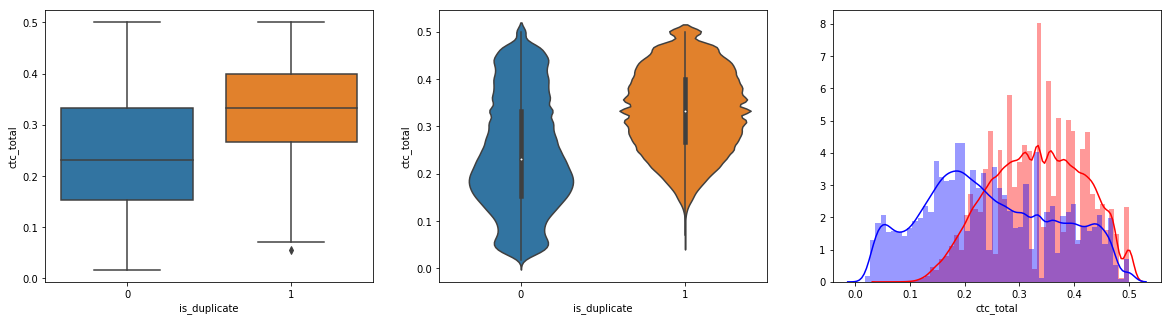

In [29]:
#Analysing ctc_total

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "ctc_total", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "ctc_total", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['ctc_total'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['ctc_total'][0:] , label = "0" , color = 'blue')

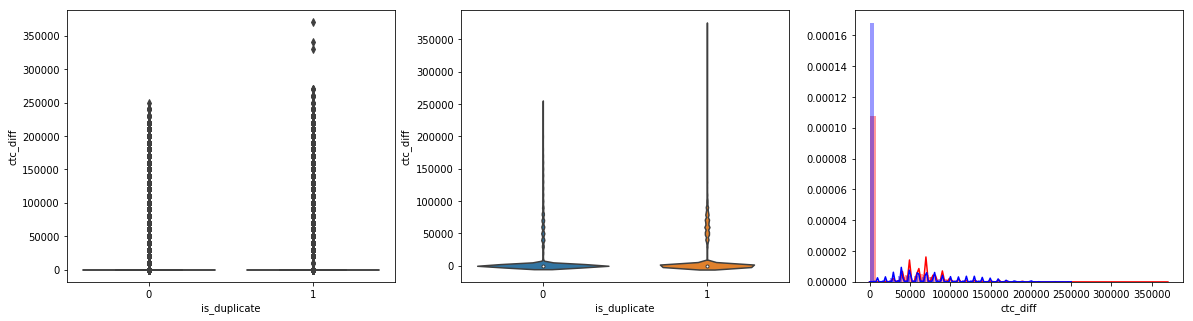

In [30]:
#Analysing ctc_diff

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "ctc_diff", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "ctc_diff", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['ctc_diff'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['ctc_diff'][0:] , label = "0" , color = 'blue')

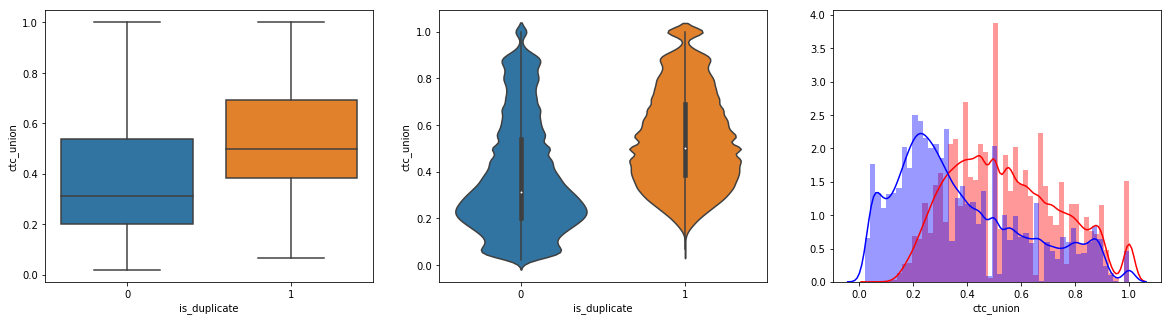

In [31]:
#Analysing ctc_union

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "ctc_union", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "ctc_union", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['ctc_union'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['ctc_union'][0:] , label = "0" , color = 'blue')

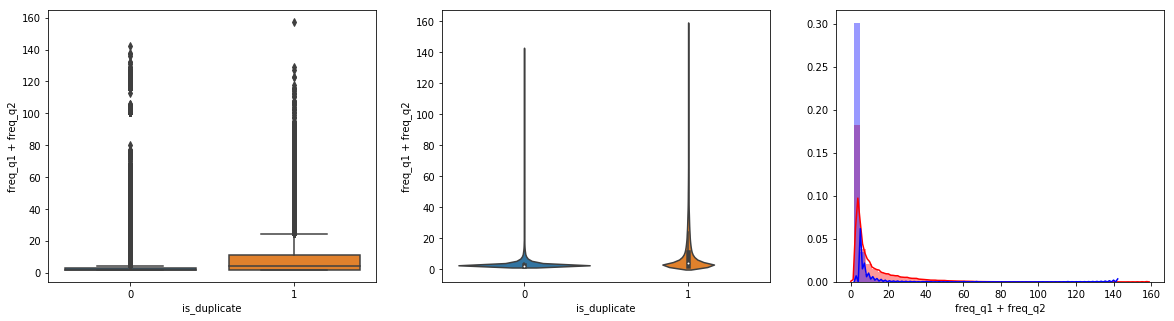

In [32]:
#Analysing freq_q1 + freq_q2

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "freq_q1 + freq_q2", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "freq_q1 + freq_q2", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['freq_q1 + freq_q2'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['freq_q1 + freq_q2'][0:] , label = "0" , color = 'blue')

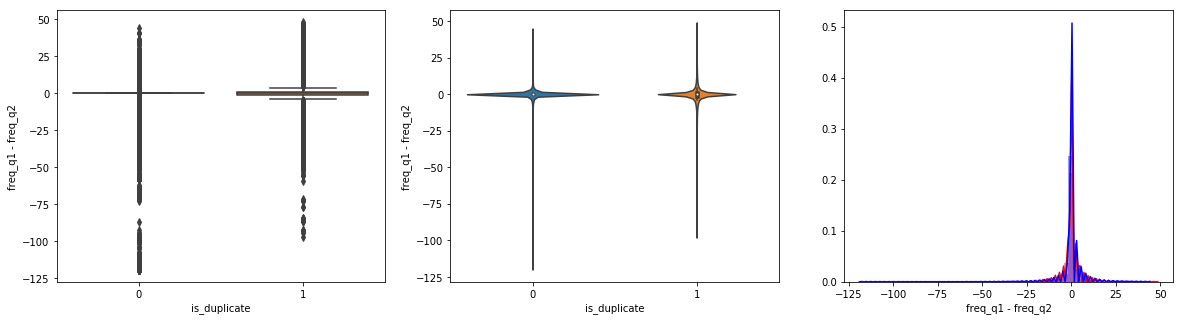

In [33]:
#Analysing freq_q1 - freq_q2

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "freq_q1 - freq_q2", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "freq_q1 - freq_q2", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['freq_q1 - freq_q2'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['freq_q1 - freq_q2'][0:] , label = "0" , color = 'blue')

# Advanced Feature Engineering

In [34]:
# Advanced feature engineering

SAFE_DIV = 0.0001
ctc_min = []
ctc_max = []
cwc_min = []
cwc_max = []
cwc_union = []
cwc_total = []
cwc_diff = []
csc_min = []
csc_max = []
csc_union = []
csc_total =[]
csc_diff =[]
sw_common = []
sw_total = []
sw_union = []
w_common = []
w_total = []
w_union = []
w_diff = []
w_mean = []
sw_diff = []
sw_mean = []

for i in range(404287):
    
    x = []
    y = []
    w1 = []
    w2 = []
    sw1 = []
    sw2 = []
    
    x = df_train["question1"].values[i].split()
    y = df_train["question2"].values[i].split()
    
    for j in x:
        if j not in stop_words:
            w1.append(j)
            
    for j in x:
        if j in stop_words:
            sw1.append(j)
            
    for j in y:
        if j not in stop_words:
            w2.append(j)
            
    for j in y:
        if j in stop_words:
            sw2.append(j)        
            
    t1 = len(x)
    t2 = len(y)
    t_c = len(set(x).intersection(set(y)))
    w_c = len(set(w1).intersection(set(w2)))
    sw_c = len(set(sw1).intersection(set(sw2)))
    w_u = len(set(w1).union(set(w2)))
    sw_u = len(set(sw1).union(set(sw2)))
    w_tot = len(w1) + len(w2)
    w_dif = abs(len(w1) - len(w2))
    w_mn = (len(w1) + len(w2))/2
    sw_tot = len(sw1) + len(sw2)
    sw_dif = abs(len(sw1) - len(sw2))
    sw_mn = (len(sw1) + len(sw2))/2
    min_t = min(t1,t2)
    max_t = max(t1,t2)
    min_w = min(len(w1),len(w2))
    max_w = max(len(w1),len(w2))
    min_sw = min(len(sw1),len(sw2))
    max_sw = max(len(sw1),len(sw2))
    
    ctc_min.append(t_c/min_t)
    ctc_max.append(t_c/max_t)
    sw_common.append(sw_c)
    sw_total.append(sw_tot)
    sw_diff.append(sw_dif)
    sw_mean.append(sw_mn)
    sw_union.append(sw_u)
    csc_min.append(sw_c/(min_sw + SAFE_DIV))
    csc_max.append(sw_c/(max_sw + SAFE_DIV))
    csc_union.append(sw_c/(sw_u + SAFE_DIV))
    csc_total.append(sw_c/(sw_tot + SAFE_DIV))
    csc_diff.append(sw_c/(sw_dif + SAFE_DIV))
    w_common.append(w_c)
    w_total.append(w_tot)
    w_diff.append(w_dif)
    w_mean.append(w_mn)
    w_union.append(w_u)
    cwc_min.append(w_c/min_w)
    cwc_max.append(w_c/max_w)
    cwc_union.append(w_c/w_u)
    cwc_total.append(w_c/w_tot)
    cwc_diff.append(w_c/(w_dif + SAFE_DIV))

In [35]:
df_train["ctc_min"] = ctc_min
df_train["ctc_max"] = ctc_max
df_train["sw_common"] = sw_common
df_train["sw_total"] = sw_total
df_train["sw_diff"] = sw_diff
df_train["sw_mean"] = sw_mean
df_train["sw_union"] = sw_union
df_train["csc_min"] = csc_min
df_train["csc_max"] = csc_max
df_train["csc_union"] = csc_union
df_train["csc_total"] = csc_total
df_train["csc_diff"] = csc_diff
df_train["w_common"] = w_common
df_train["w_total"] = w_total
df_train["w_diff"] = w_diff
df_train["w_mean"] = w_mean
df_train["w_union"] = w_union
df_train["cwc_min"] = cwc_min
df_train["cwc_max"] = cwc_max
df_train["cwc_union"] = cwc_union
df_train["cwc_total"] = cwc_total
df_train["cwc_diff"] = cwc_diff

In [36]:
df_train.head()

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guid to invest in sha...   
1   1     3     4  what is the stori of kohinoor koh noor diamond...   
2   2     5     6  how can increas the speed of my internet conne...   
3   3     7     8     whi am mental veri lone how can solv it dollar   
4   4     9    10  which one dissolv in water quik sugar salt met...   

                                           question2  is_duplicate  freq_q1  \
0  what is the step by step guid to invest in sha...             0        1   
1  what would happen if the indian govern stole t...             0        4   
2  how can internet speed be increas by hack thro...             0        1   
3  find the remaind when math math is divid by do...             0        1   
4       which fish would surviv in salt water dollar             0        3   

   freq_q2  freq_q1 + freq_q2  freq_q1 - freq_q2      ...       w_common  \
0        1                  2                  0      ...              6   
1        1                  5                  3      ...              5   
2        1                  2                  0      ...              4   
3        1                  2                  0      ...              1   
4        1                  4                  2      ...              3   

   w_total  w_diff  w_mean  w_union   cwc_min   cwc_max  cwc_union  cwc_total  \
0       15       1     7.5        7  0.857143  0.750000   0.857143   0.400000   
1       17       5     8.5       12  0.833333  0.454545   0.416667   0.294118   
2       13       1     6.5        9  0.666667  0.571429   0.444444   0.307692   
3       12       0     6.0       10  0.166667  0.166667   0.100000   0.083333   
4       17       5     8.5       14  0.500000  0.272727   0.214286   0.176471   

       cwc_diff  
0      5.999400  
1      0.999980  
2      3.999600  
3  10000.000000  
4      0.599988  

[5 rows x 42 columns]

# Feature Analysis

## Univariate analysis

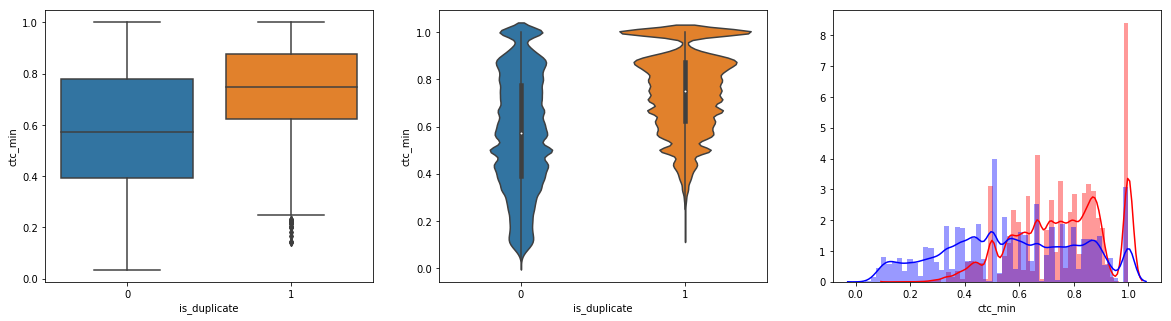

In [37]:
#Analysing ctc_min

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "ctc_min", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "ctc_min", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['ctc_min'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['ctc_min'][0:] , label = "0" , color = 'blue')

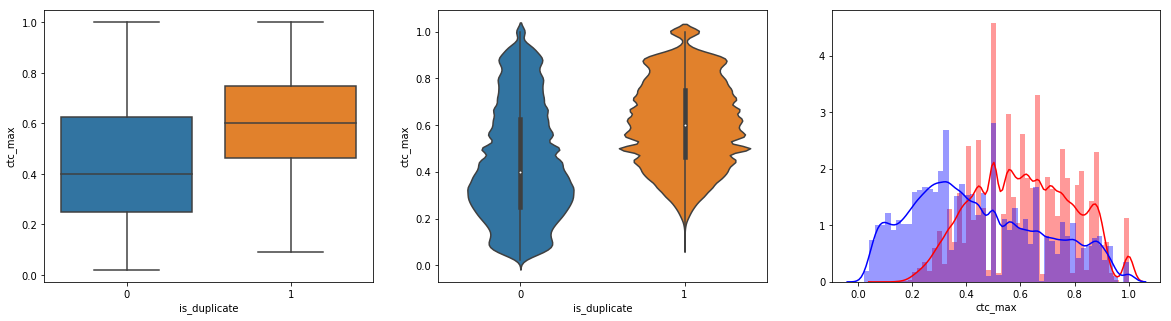

In [38]:
#Analysing ctc_max

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "ctc_max", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "ctc_max", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['ctc_max'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['ctc_max'][0:] , label = "0" , color = 'blue')

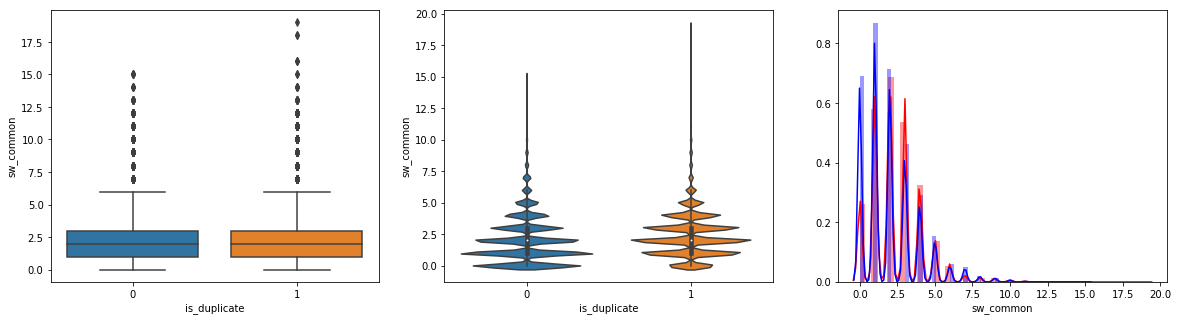

In [39]:
#Analysing sw_common

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "sw_common", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "sw_common", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['sw_common'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['sw_common'][0:] , label = "0" , color = 'blue')

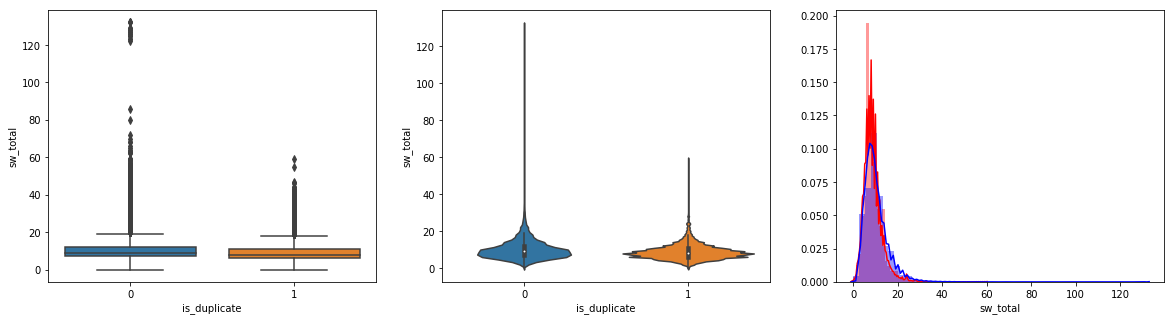

In [40]:
#Analysing sw_total

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "sw_total", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "sw_total", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['sw_total'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['sw_total'][0:] , label = "0" , color = 'blue')

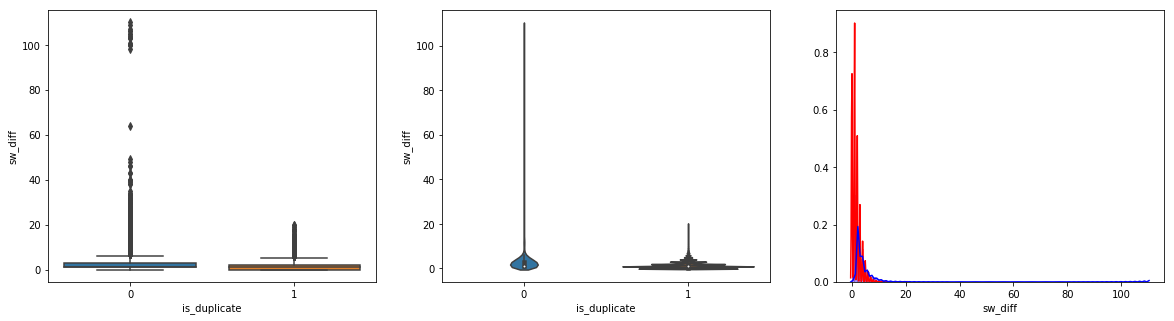

In [41]:
#Analysing sw_diff

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "sw_diff", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "sw_diff", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['sw_diff'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['sw_diff'][0:] , label = "0" , color = 'blue')

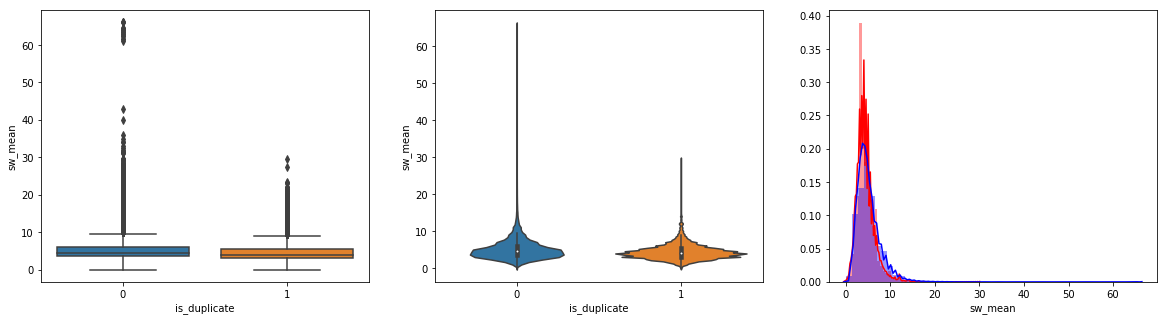

In [42]:
#Analysing sw_mean

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "sw_mean", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "sw_mean", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['sw_mean'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['sw_mean'][0:] , label = "0" , color = 'blue')

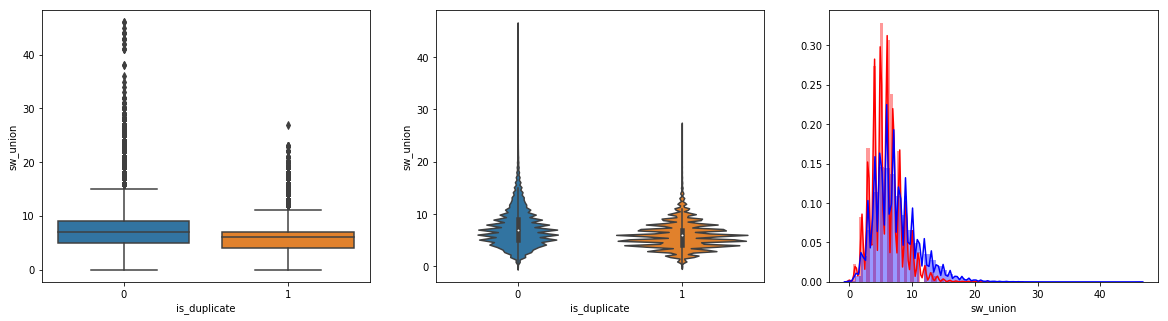

In [43]:
#Analysing sw_union

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "sw_union", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "sw_union", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['sw_union'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['sw_union'][0:] , label = "0" , color = 'blue')

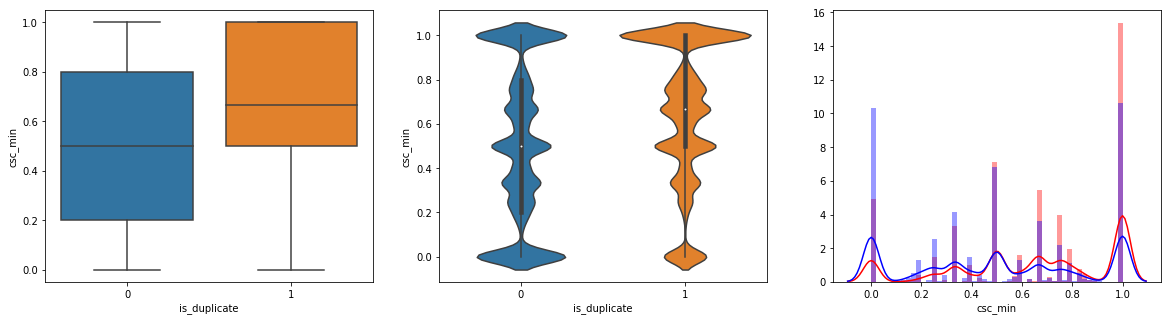

In [44]:
#Analysing csc_min

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "csc_min", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "csc_min", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['csc_min'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['csc_min'][0:] , label = "0" , color = 'blue')

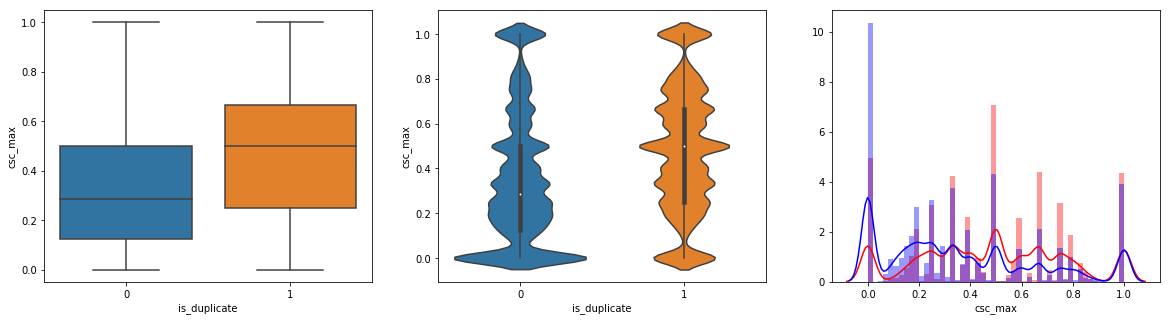

In [45]:
#Analysing csc_max

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "csc_max", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "csc_max", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['csc_max'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['csc_max'][0:] , label = "0" , color = 'blue')

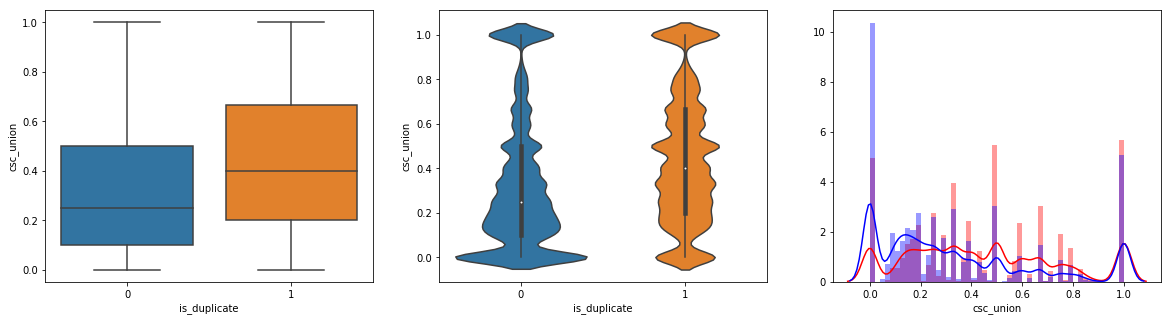

In [46]:
#Analysing csc_union

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "csc_union", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "csc_union", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['csc_union'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['csc_union'][0:] , label = "0" , color = 'blue')

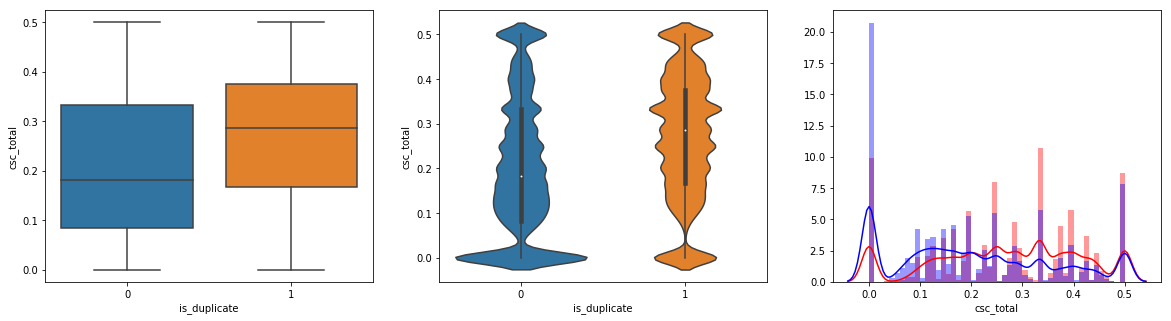

In [47]:
#Analysing csc_total

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "csc_total", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "csc_total", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['csc_total'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['csc_total'][0:] , label = "0" , color = 'blue')

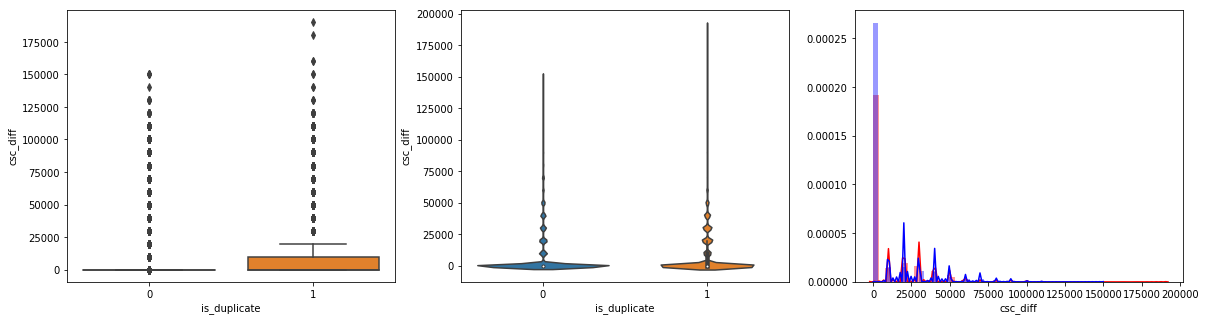

In [48]:
#Analysing csc_diff

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "csc_diff", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "csc_diff", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['csc_diff'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['csc_diff'][0:] , label = "0" , color = 'blue')

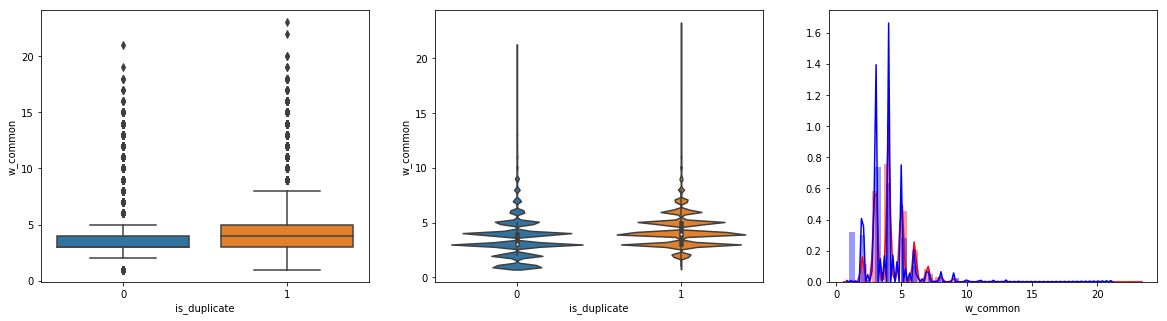

In [49]:
#Analysing w_common

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "w_common", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "w_common", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['w_common'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['w_common'][0:] , label = "0" , color = 'blue')

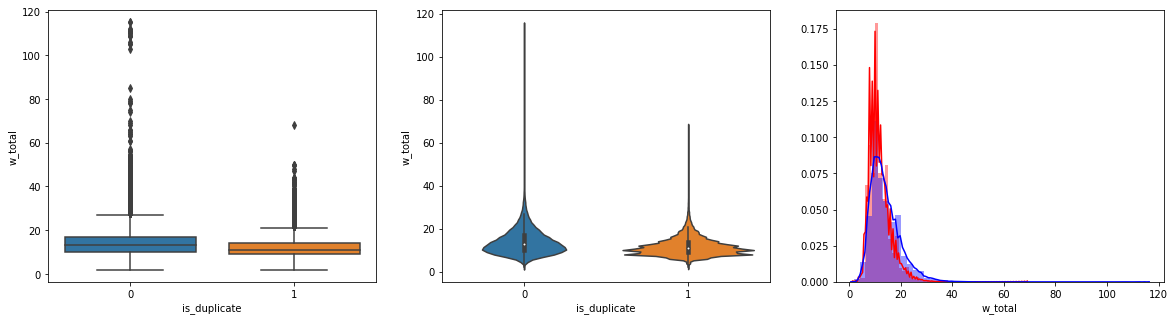

In [50]:
#Analysing w_total

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "w_total", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "w_total", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['w_total'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['w_total'][0:] , label = "0" , color = 'blue')

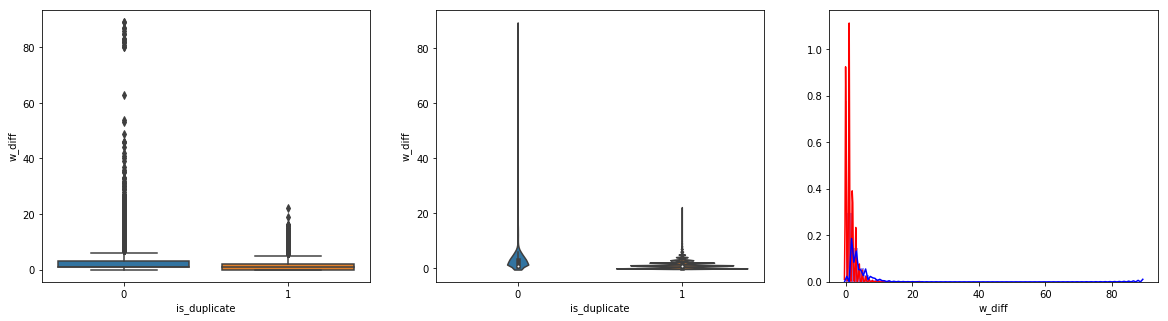

In [51]:
#Analysing w_diff

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "w_diff", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "w_diff", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['w_diff'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['w_diff'][0:] , label = "0" , color = 'blue')

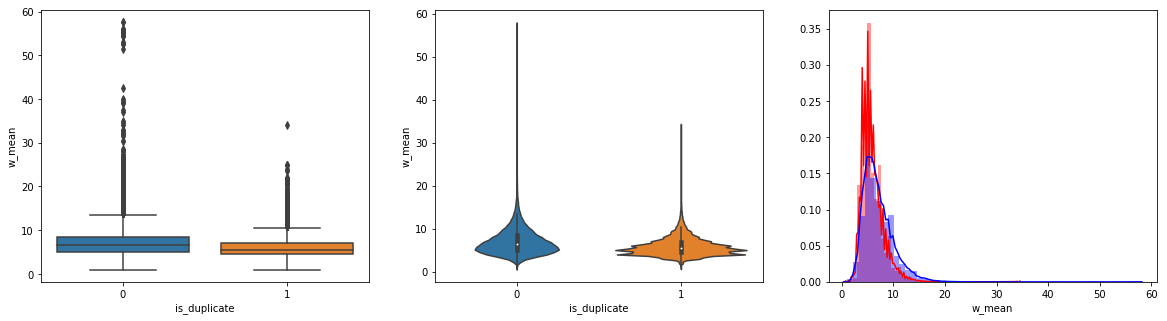

In [52]:
#Analysing w_mean

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "w_mean", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "w_mean", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['w_mean'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['w_mean'][0:] , label = "0" , color = 'blue')

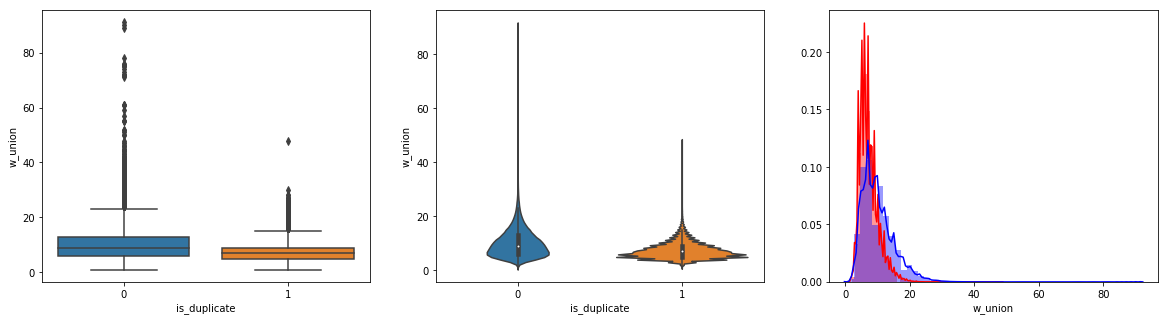

In [53]:
#Analysing w_union

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "w_union", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "w_union", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['w_union'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['w_union'][0:] , label = "0" , color = 'blue')

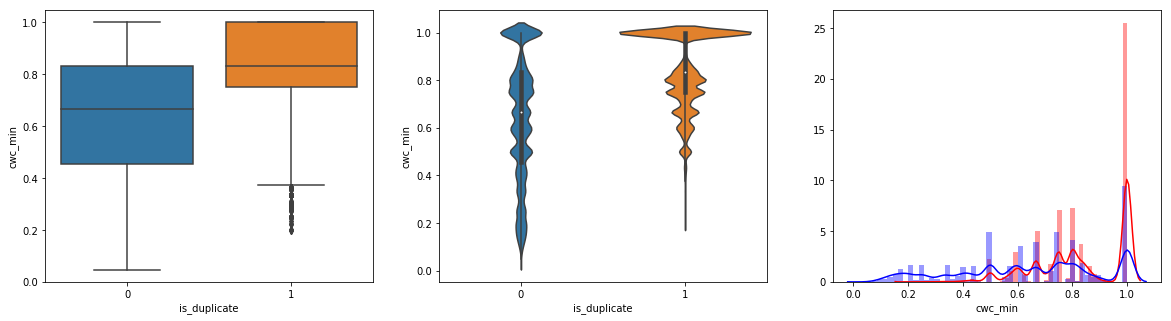

In [54]:
#Analysing cwc_min

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "cwc_min", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "cwc_min", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['cwc_min'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['cwc_min'][0:] , label = "0" , color = 'blue')

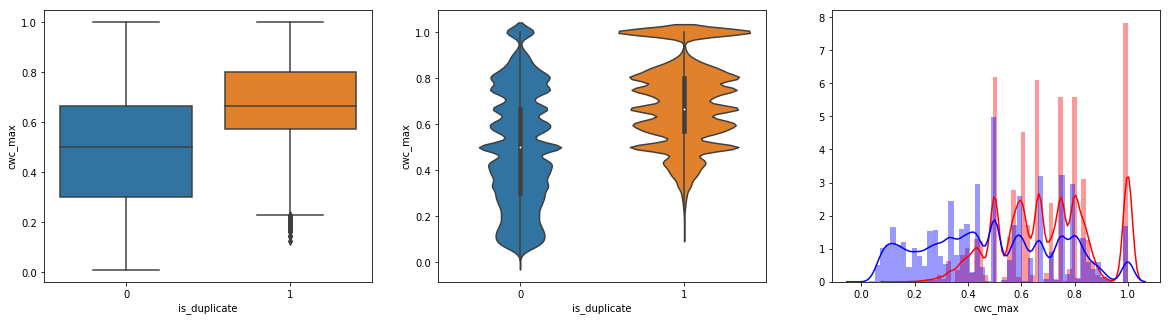

In [55]:
#Analysing cwc_max

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "cwc_max", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "cwc_max", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['cwc_max'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['cwc_max'][0:] , label = "0" , color = 'blue')

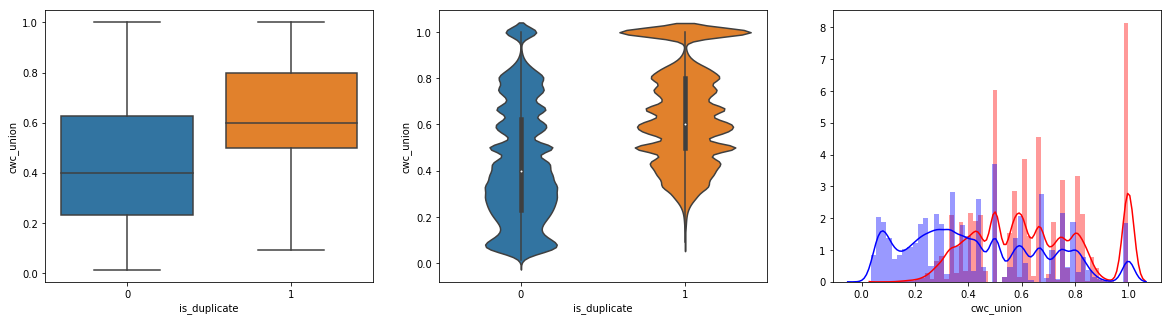

In [56]:
#Analysing cwc_union

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "cwc_union", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "cwc_union", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['cwc_union'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['cwc_union'][0:] , label = "0" , color = 'blue')

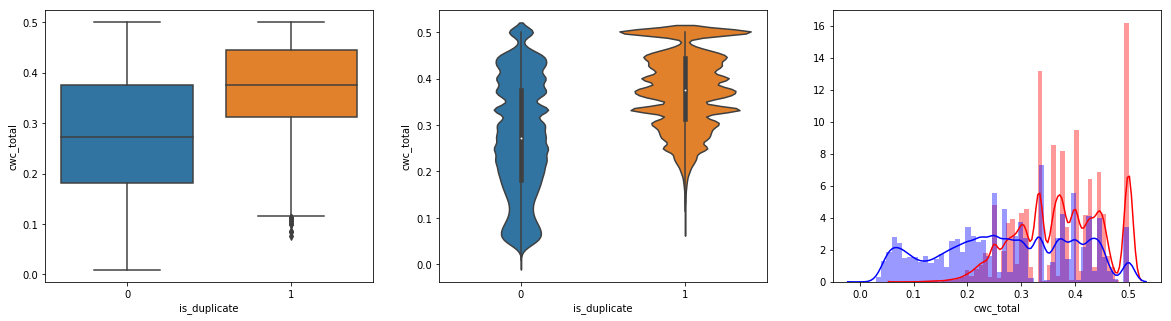

In [57]:
#Analysing cwc_total

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "cwc_total", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "cwc_total", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['cwc_total'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['cwc_total'][0:] , label = "0" , color = 'blue')

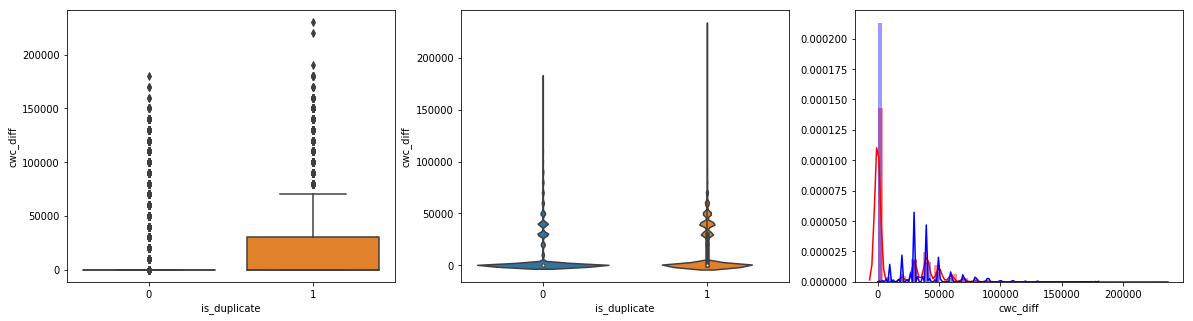

In [58]:
#Analysing cwc_diff

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "cwc_diff", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "cwc_diff", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['cwc_diff'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['cwc_diff'][0:] , label = "0" , color = 'blue')

## Bivariate Analysis

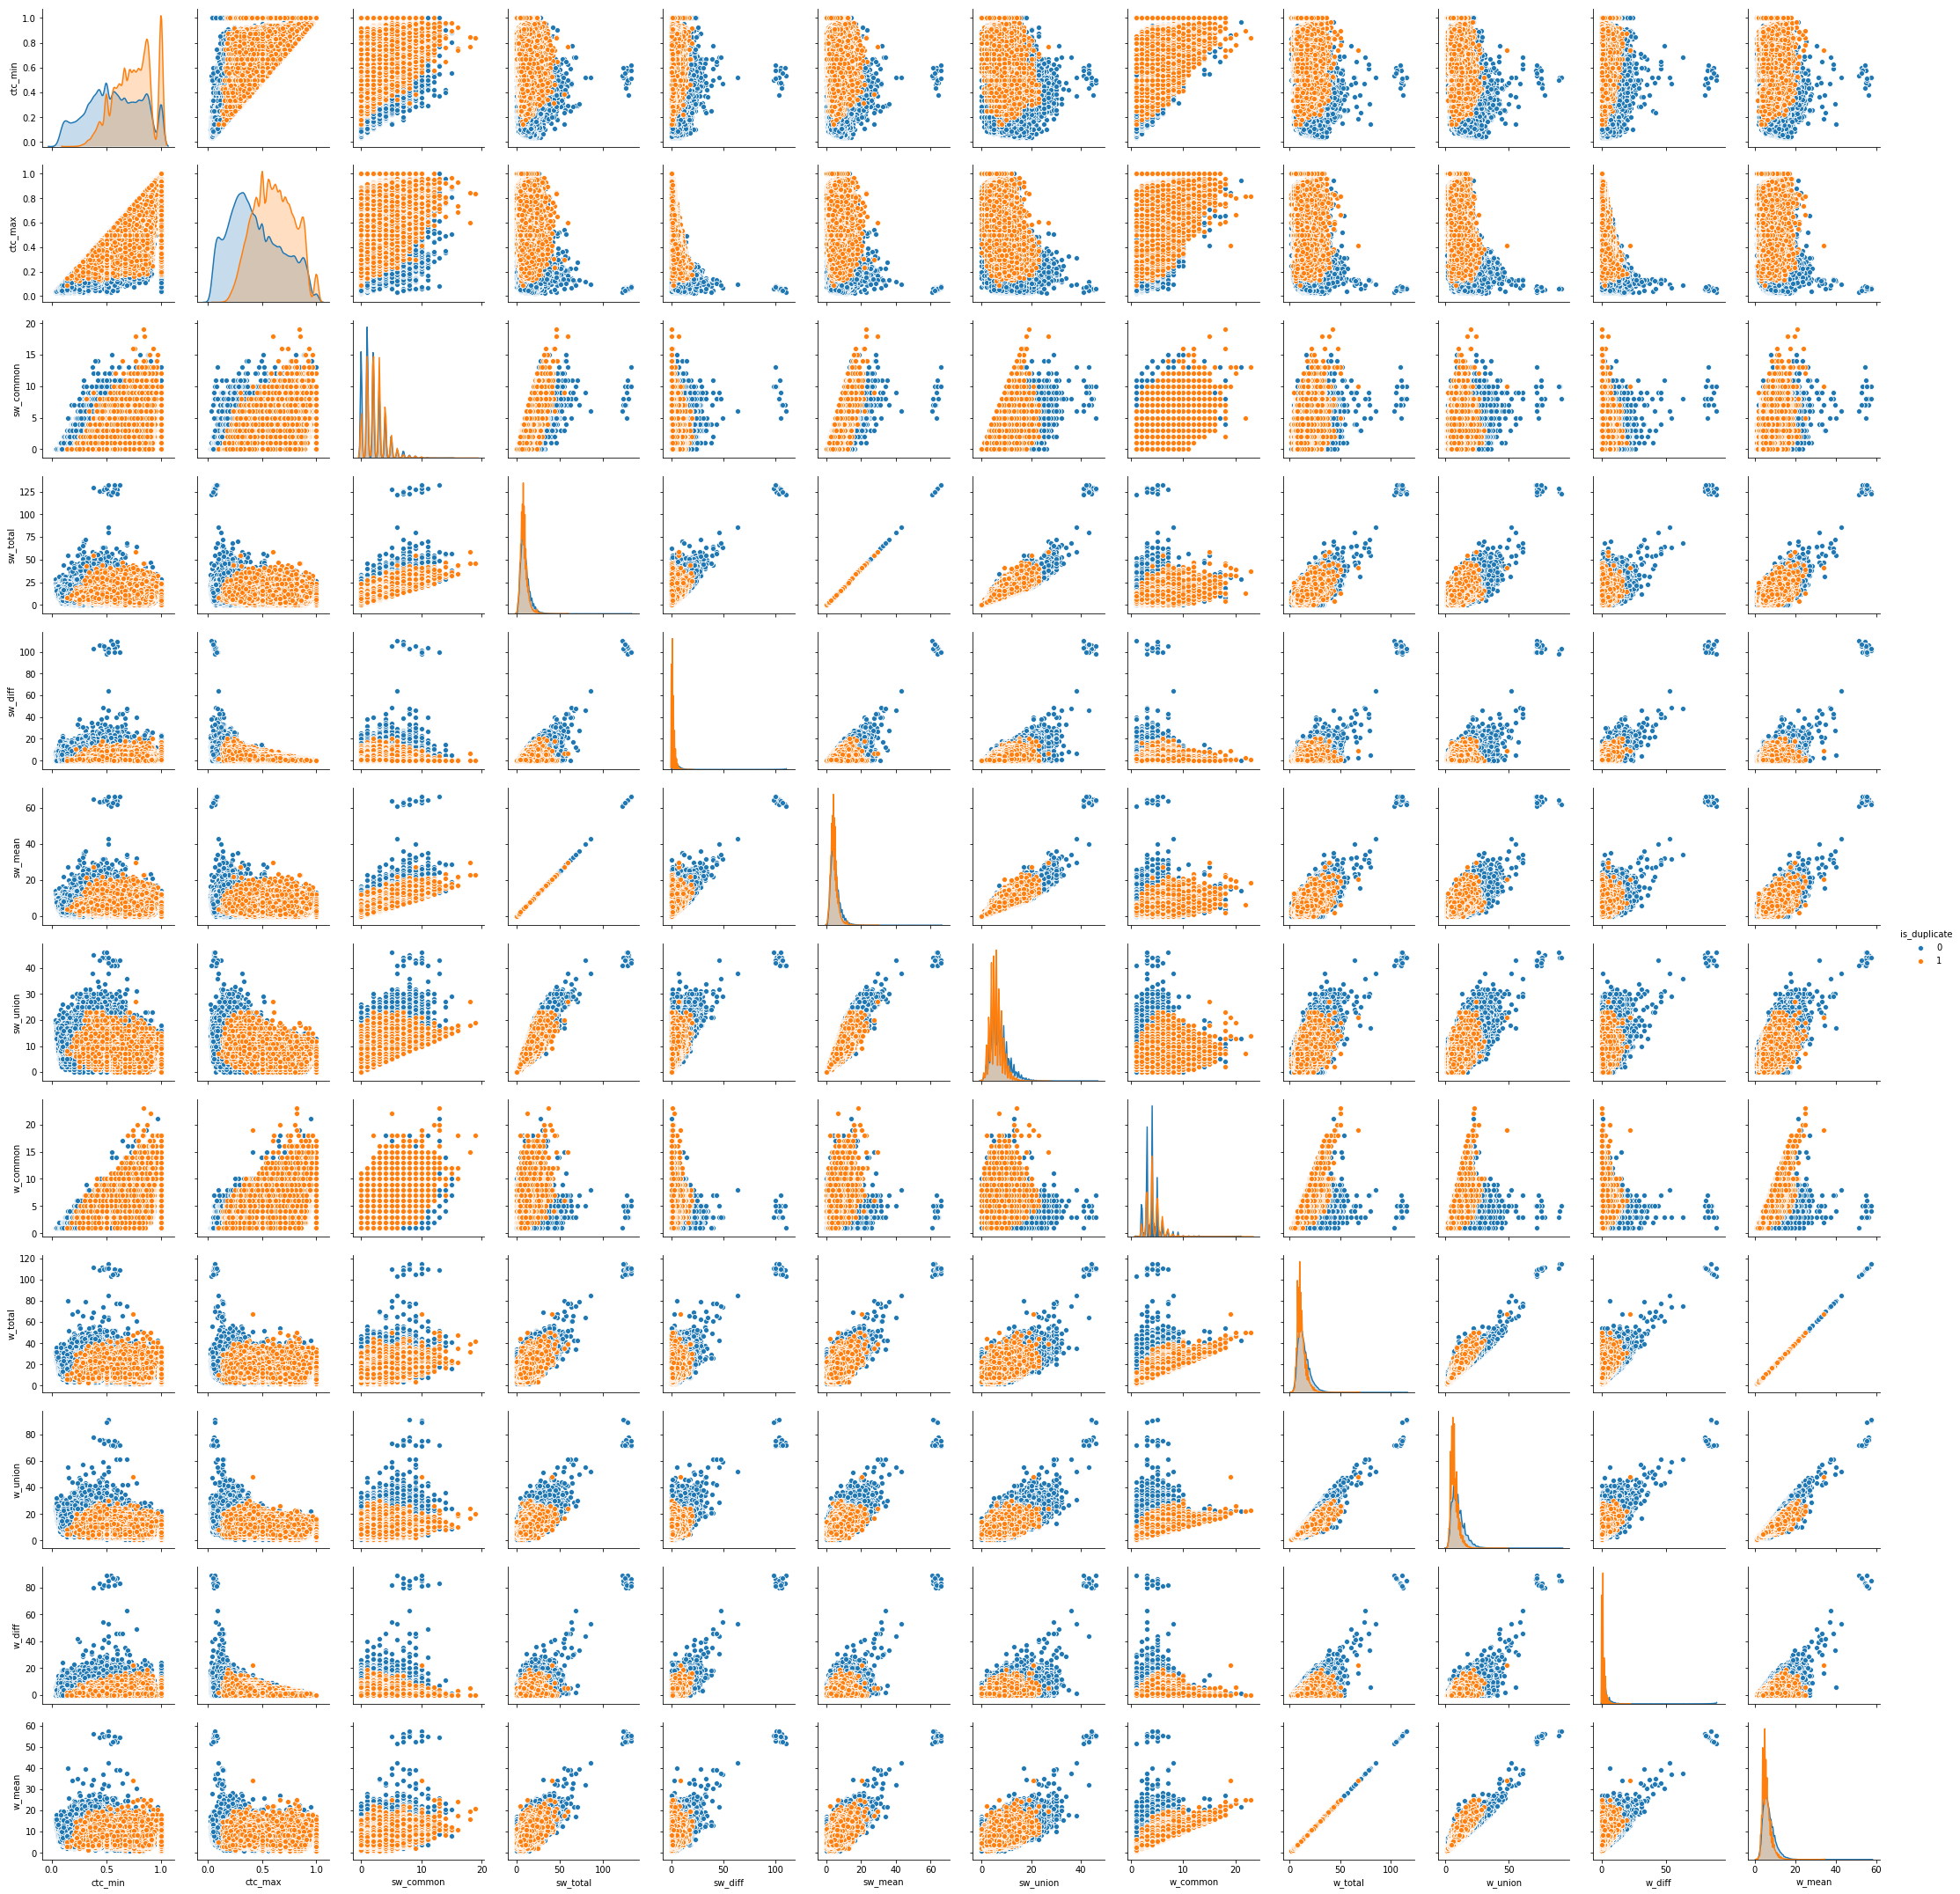

In [59]:
sns.pairplot(df_train, vars = ['ctc_min', 'ctc_max', 'sw_common', 'sw_total', 'sw_diff', 'sw_mean', 'sw_union', 'w_common', 'w_total', 'w_union', 'w_diff', 'w_mean'], hue ='is_duplicate')

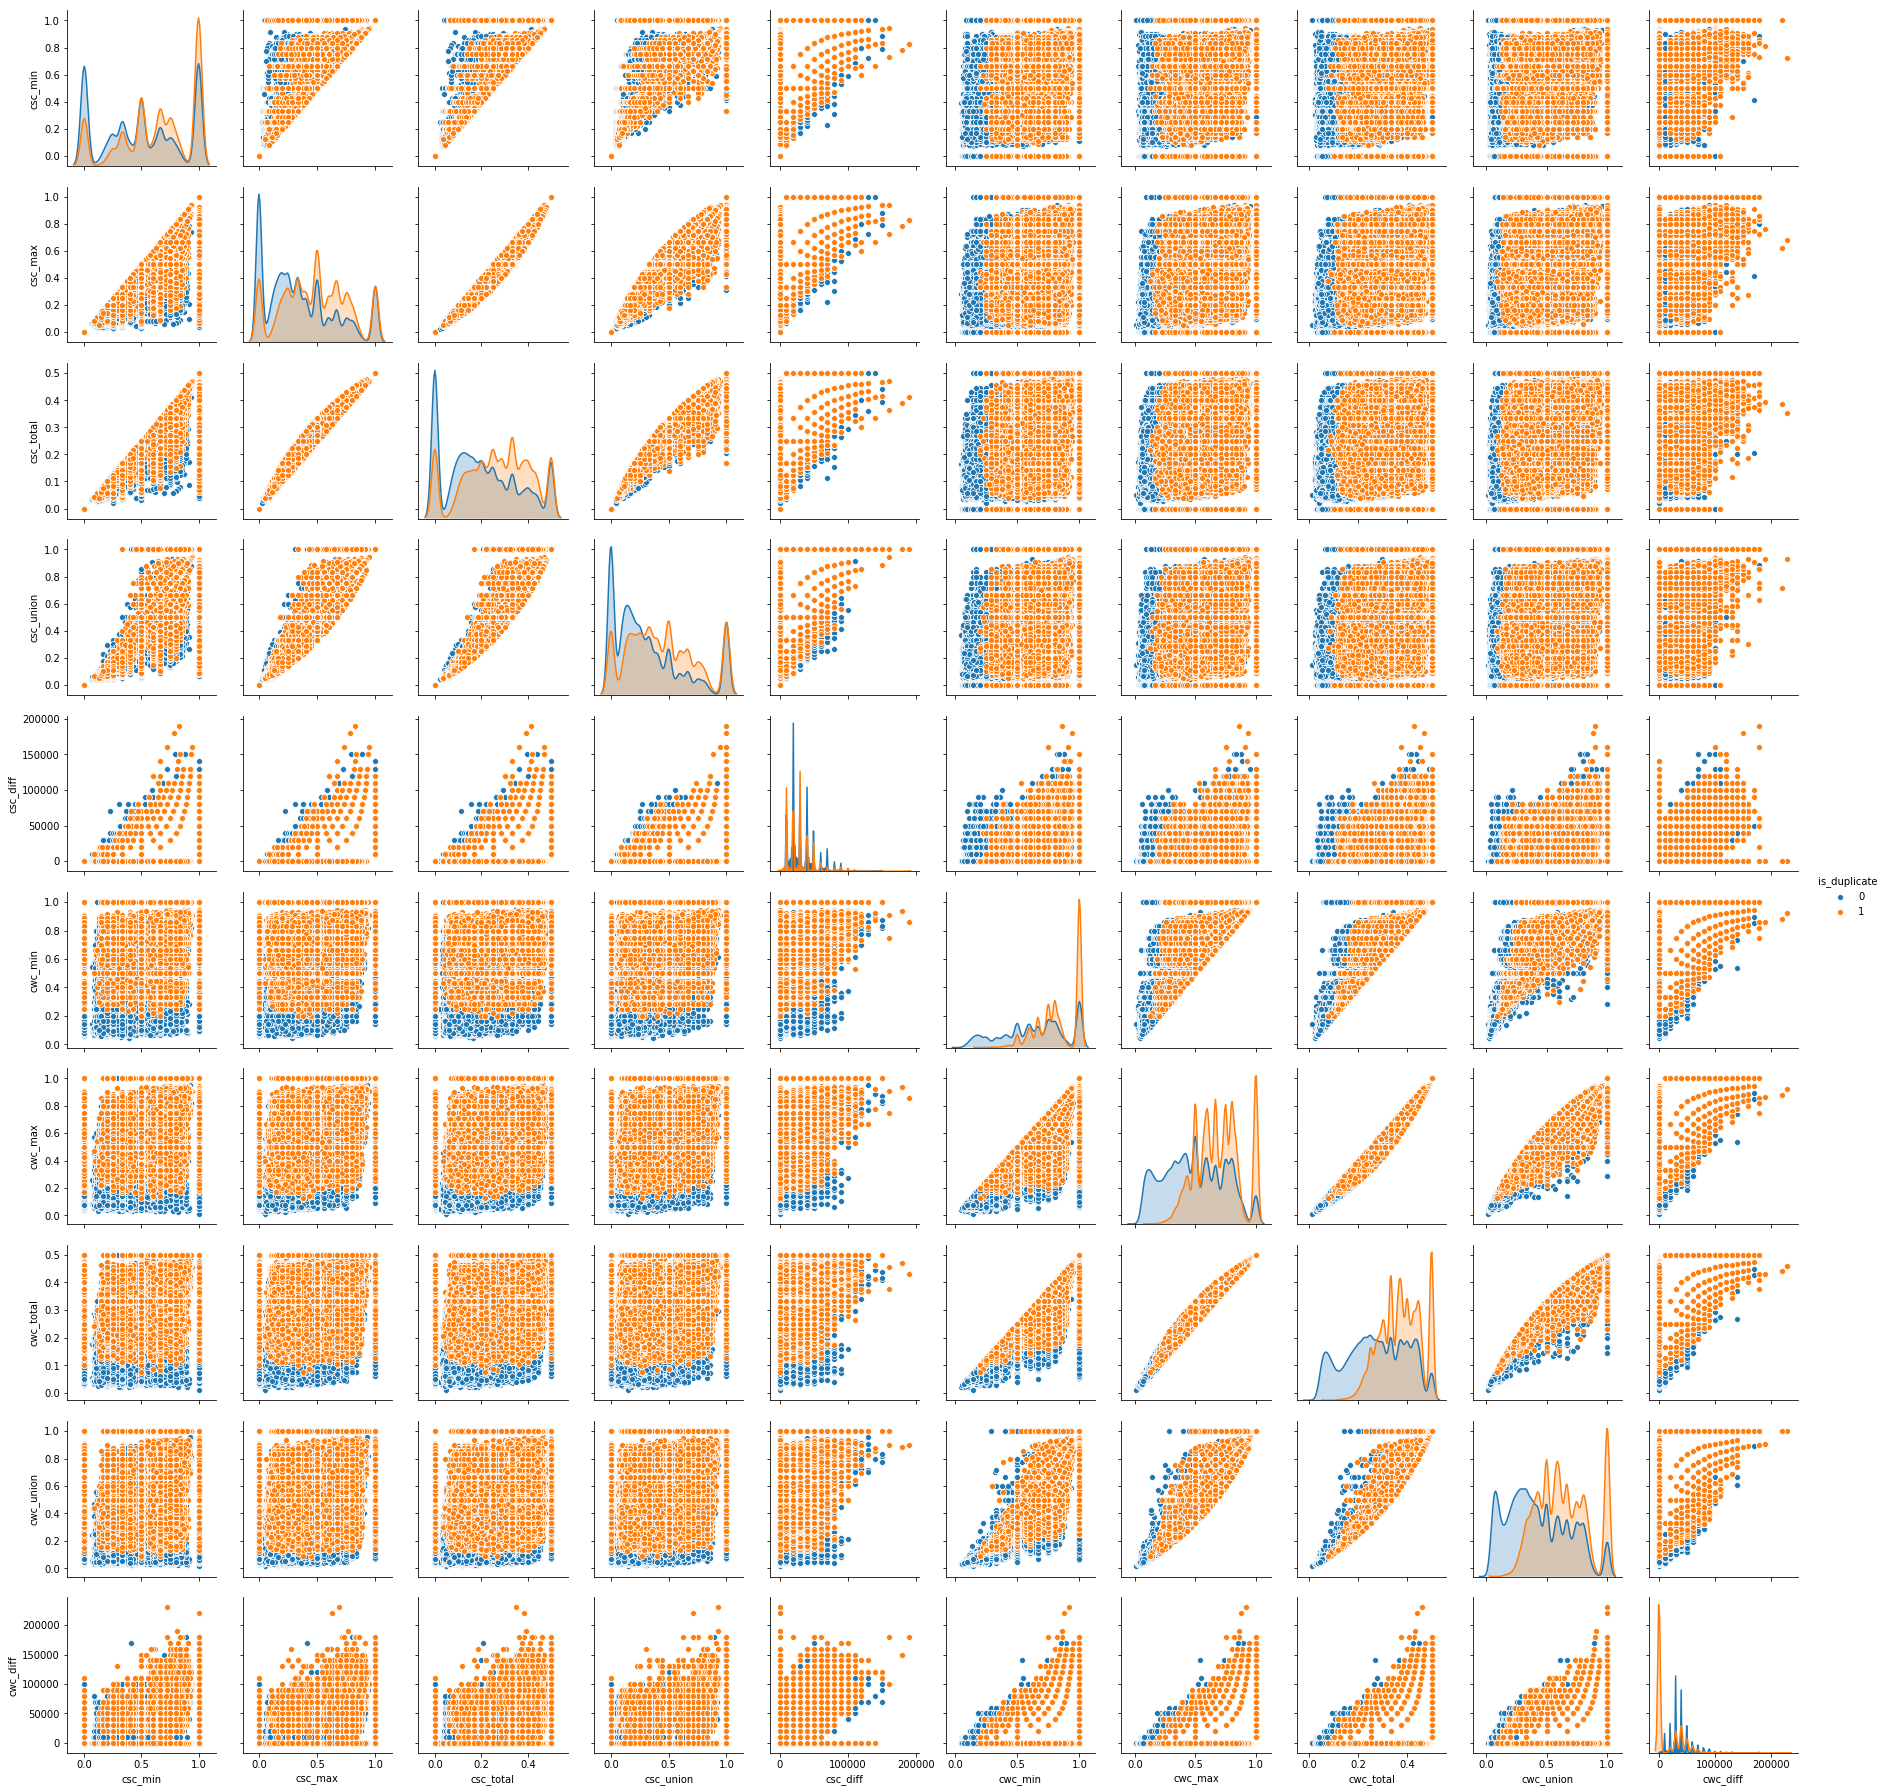

In [60]:
sns.pairplot(df_train, vars = ['csc_min', 'csc_max', 'csc_total', 'csc_union', 'csc_diff','cwc_min', 'cwc_max','cwc_total', 'cwc_union', 'cwc_diff'], hue ='is_duplicate')

# Adding fuzzy features

In [61]:
token_set_ratio = []
token_sort_ratio = []
QRatio = []
partial_ratio = []

for ques1, ques2 in zip(df_train["question1"].values, df_train["question2"].values):
    
    tsr_1 = fuzz.token_set_ratio(ques1, ques2)
    tsr_2 = fuzz.token_sort_ratio(ques1, ques2)
    qr = fuzz.QRatio(ques1, ques2)
    pr = fuzz.partial_ratio(ques1, ques2)
    
    token_set_ratio.append(tsr_1)
    token_sort_ratio.append(tsr_2)
    QRatio.append(qr)
    partial_ratio.append(pr)

In [62]:
df_train["token_set_ratio"] = token_set_ratio
df_train["token_sort_ratio"] = token_sort_ratio
df_train["QRatio"] = QRatio
df_train["partial_ratio"] = partial_ratio

# Feature Analysis

## Univariate Analysis

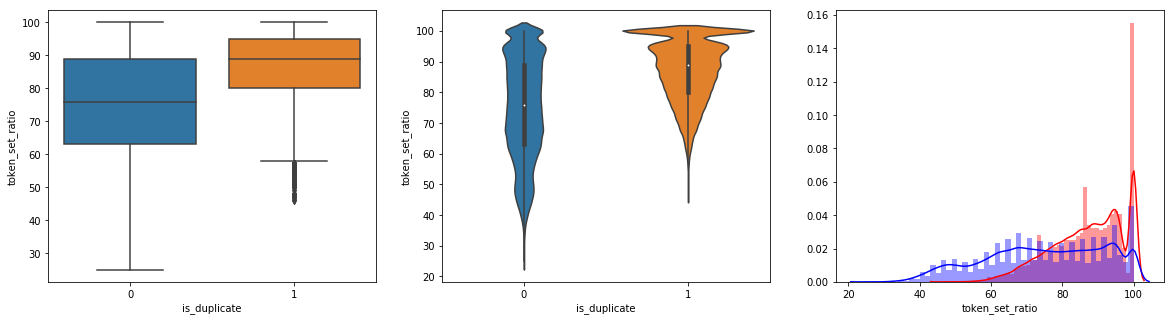

In [63]:
#Analysing token_set_ratio

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "token_set_ratio", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "token_set_ratio", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue')

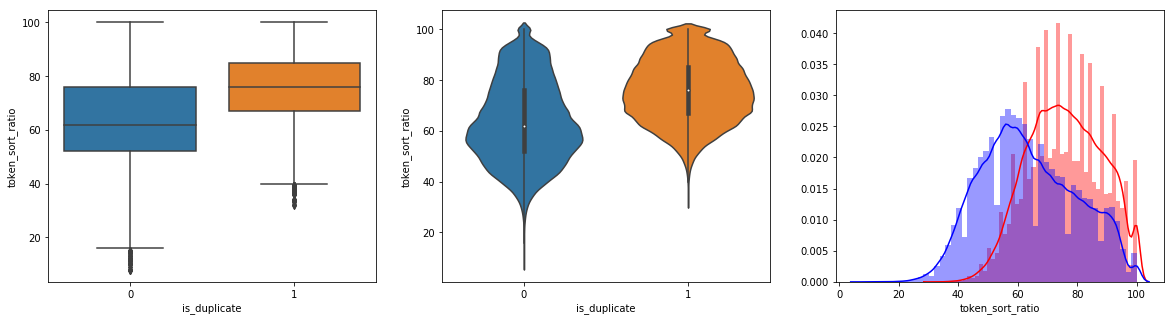

In [64]:
#Analysing token_sort_ratio

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "token_sort_ratio", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "token_sort_ratio", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue')

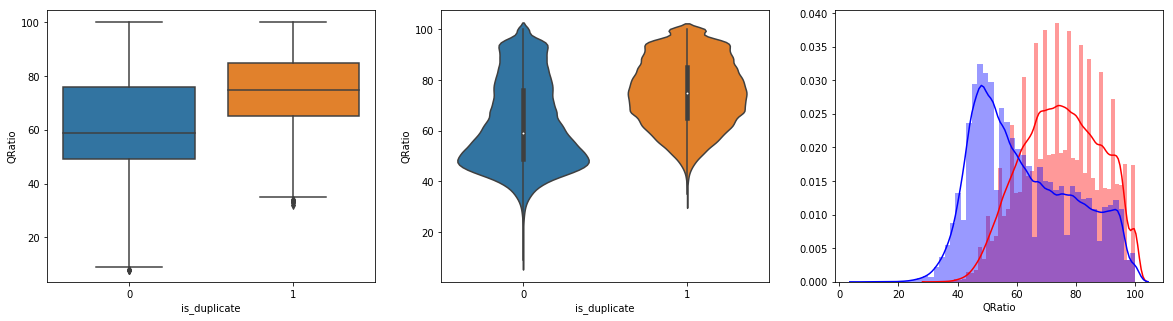

In [65]:
#Analysing QRatio

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "QRatio", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "QRatio", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['QRatio'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['QRatio'][0:] , label = "0" , color = 'blue')

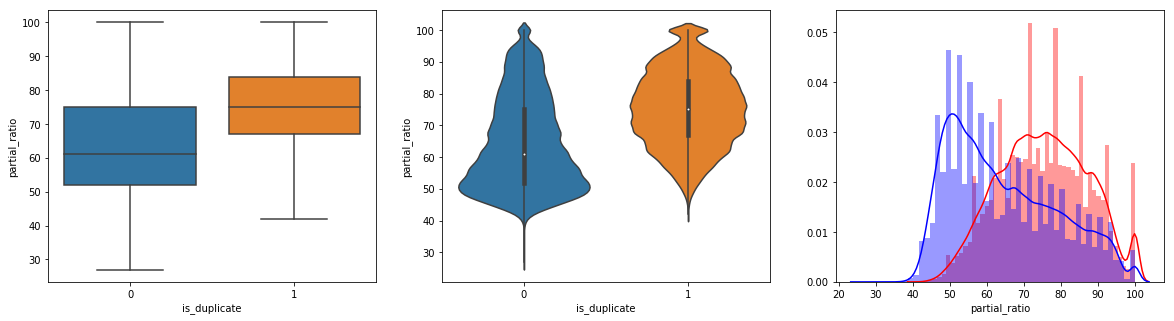

In [66]:
#Analysing partial_ratio

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.boxplot(x = "is_duplicate", y = "partial_ratio", data = df_train)

plt.subplot(1,3,2)
sns.violinplot(x = "is_duplicate", y = "partial_ratio", data = df_train)

plt.subplot(1,3,3)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['partial_ratio'][0:] , label = "0" , color = 'blue')

## bivariate analysis

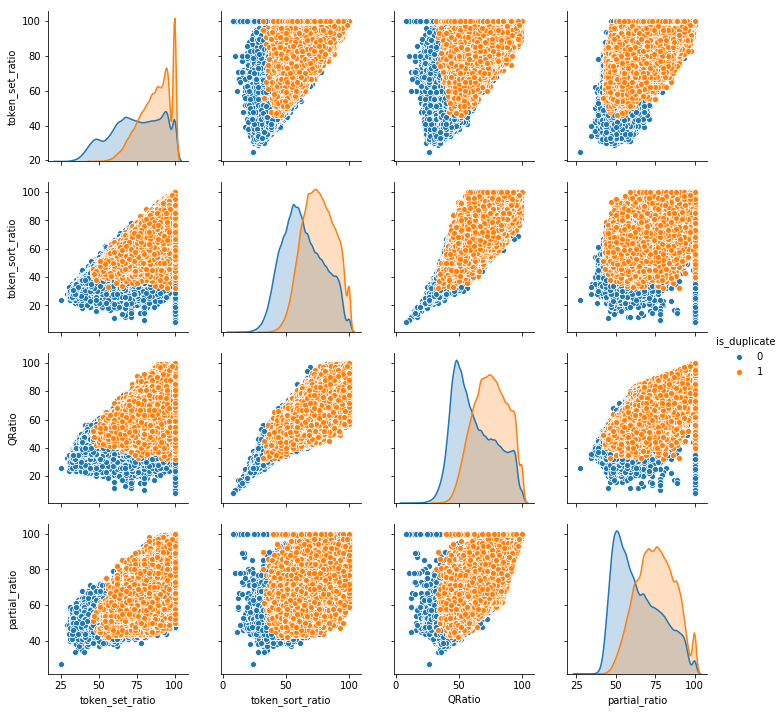

In [67]:
sns.pairplot(df_train, vars = ['token_set_ratio', 'token_sort_ratio', 'QRatio', 'partial_ratio'], hue ='is_duplicate')

## Stop word removal

In [68]:
question1 = []
question2 = []

for i in range(404287):
    
    q1 = []
    q2 = []
    
    for j in df_train["question1"].values[i].split():
        if j not in stop_words:
            q1.append(j)
            
    for k in df_train["question2"].values[i].split():
        if k not in stop_words:
            q2.append(k)
            
    str1 = ' '.join(str(e) for e in q1)
    str2 = ' '.join(str(e) for e in q2)
            
    question1.append(str1)
    question2.append(str2)

In [69]:
df_train["question1"] = question1
df_train["question2"] = question2

In [70]:
df_train.head()

id  qid1  qid2                                          question1  \
0   0     1     2    step step guid invest share market india dollar   
1   1     3     4             stori kohinoor koh noor diamond dollar   
2   2     5     6      increas speed internet connect use vpn dollar   
3   3     7     8                   whi mental veri lone solv dollar   
4   4     9    10  one dissolv water quik sugar salt methan carbo...   

                                           question2  is_duplicate  freq_q1  \
0          step step guid invest share market dollar             0        1   
1  would happen indian govern stole kohinoor koh ...             0        4   
2             internet speed increas hack dns dollar             0        1   
3                find remaind math math divid dollar             0        1   
4                fish would surviv salt water dollar             0        3   

   freq_q2  freq_q1 + freq_q2  freq_q1 - freq_q2      ...        w_union  \
0        1                  2                  0      ...              7   
1        1                  5                  3      ...             12   
2        1                  2                  0      ...              9   
3        1                  2                  0      ...             10   
4        1                  4                  2      ...             14   

    cwc_min   cwc_max  cwc_union  cwc_total      cwc_diff  token_set_ratio  \
0  0.857143  0.750000   0.857143   0.400000      5.999400              100   
1  0.833333  0.454545   0.416667   0.294118      0.999980               87   
2  0.666667  0.571429   0.444444   0.307692      3.999600               76   
3  0.166667  0.166667   0.100000   0.083333  10000.000000               46   
4  0.500000  0.272727   0.214286   0.176471      0.599988               74   

   token_sort_ratio  QRatio  partial_ratio  
0                93      93             92  
1                68      69             74  
2                68      60             53  
3                44      48             48  
4                54      50             52  

[5 rows x 46 columns]

In [71]:
df_train.to_csv("preprocessed1.csv", index = False)

# TSNE Visualization

In [72]:
df_sample = df_train[0:5000]

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x = mms.fit_transform(df_sample[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'token_set_ratio' , 'token_sort_ratio' ,  'QRatio' , 'partial_ratio' ]])
y = df_sample['is_duplicate'].values

In [73]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state = 0,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.472s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000095
[t-SNE] Computed conditional probabilities in 0.343s
[t-SNE] Iteration 50: error = 84.9864578, gradient norm = 0.0481683 (50 iterations in 11.630s)
[t-SNE] Iteration 100: error = 73.1866913, gradient norm = 0.0066904 (50 iterations in 9.707s)
[t-SNE] Iteration 150: error = 71.9231186, gradient norm = 0.0034263 (50 iterations in 9.347s)
[t-SNE] Iteration 200: error = 71.5071869, gradient norm = 0.0046660 (50 iterations in 10.468s)
[t-SNE] Iteration 250: error = 71.3154907, gradient norm = 0.00174

C:\Users\prane\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


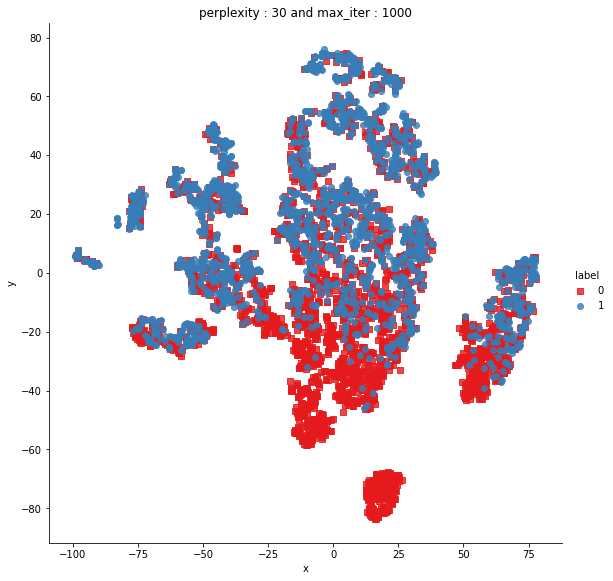

In [74]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()